In [28]:
import sys
import os
import importlib
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pygwalker as pyg
from IPython.display import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import HTML

project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(os.path.join(project_dir, 'utilities'))
import utilities as utils

config_path = os.path.join(project_dir, 'config', 'datasets_config.json')
with open (config_path) as json_config:
    config_options = json.load(json_config)

In [24]:
# Import if using in a the notebook within a browser
# display(HTML("<style>.container { width:90% !important; }</style>"))

In [57]:
# Run if changes are made to the datasets_config file or utilities
importlib.reload(utils)
with open (config_path) as json_config:
    config_options = json.load(json_config)

<module 'utilities' from 'c:\\Users\\Jonah\\Development\\ml-prediction-correlation-visualization\\utilities\\utilities.py'>

In [25]:
ml_results_dir = os.path.join(project_dir, 'results', 'life-expectancy-who_20231128_1351')

In [92]:
model_test_results = pd.read_csv(os.path.join(ml_results_dir, 'test_results.csv'), index_col=0)
model_test_results

,model_key,model_name,training_x,r2_score,shuffled_r2_score,best_hyperparameters
0,rr,Ridge regression,X,0.815194,-0.949060,"{'imputer__strategy': 'mean', 'regressor__alph..."
1,rr,Ridge regression,X_with_covar,0.956095,NaN,"{'imputer__strategy': 'median', 'regressor__al..."
2,rr,Ridge regression,X_shuffled,-0.000913,NaN,"{'imputer__strategy': 'constant', 'regressor__..."
3,rfr,Random forest regression,X,0.964471,-1.031899,"{'imputer__strategy': 'constant', 'regressor__..."
4,rfr,Random forest regression,X_with_covar,0.966849,NaN,"{'imputer__strategy': 'constant', 'regressor__..."
5,rfr,Random forest regression,X_shuffled,-0.058850,NaN,"{'imputer__strategy': 'median', 'regressor__ma..."


#### Training results observations and notes
- Including the covariates during training had a marginal effect on the random forest performance
- Including the covariates during training boosted the performance of ridge regression quite a bit
- Interestingly, the imputer strategy of filling in missing values with 0 ('constant' strategy) led to the best performing random forest
- Notes:
    - The results corresponding to X_shuffled under the column training_x means the model was trained with a shuffled X_training matrix and applied to X_test
    - The results under the column shuffled_r2_score means the model was trained with the X_training matrix and applied to a shuffled X_test
- __We will focus on the random forest model trained on the X matrix without covariates__

In [93]:
model_dir = os.path.join(ml_results_dir, 'rfr_X')
y_test_predictions = pd.read_csv(os.path.join(model_dir, 'y_test_predictions.csv'), index_col=0)
y_test_predictions.head()

,true,prediction
2225,65.1,64.912
838,56.2,56.227
2405,54.0,54.590
1969,75.8,75.539
305,74.0,72.483


In [30]:
config = config_options['life-expectancy-who']

io_dir = os.path.join(config['io_dir'].replace('/', os.sep))
input_dir = os.path.join(io_dir, 'input')
output_dir = os.path.join(io_dir, 'output')
df = pd.read_csv(os.path.join(input_dir, 'df.csv'), index_col=0)
df.head()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [31]:
# This is equivalent to the 'True' column in y_test_predictions
target_variable = 'Life expectancy'
X = df.drop(target_variable, axis=1)
X_test = X.reindex(y_test_predictions.index)
# Sanity check
y_test_predictions.shape
X_test.shape
X_test.head()

(293, 2)

(293, 18)

,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2225,217.0,0,4.14,49.936982,87.0,0,24.7,0,98.0,7.44,97.0,1.2,894.927988,16311.0,6.7,6.6,0.527,10.3
838,344.0,3,10.99,1493.051277,NaN,0,22.6,4,39.0,3.29,41.0,7.7,21451.886170,99429.0,8.9,8.8,0.580,9.2
2405,485.0,55,6.93,519.156378,71.0,244,42.2,82,7.0,8.26,69.0,28.9,3775.682750,46418193.9,13.5,16.1,0.613,12.9
1969,122.0,1,5.53,623.910050,92.0,0,5.3,2,88.0,7.48,92.0,0.1,4916.548860,333465.0,2.1,2.1,0.740,12.9
305,189.0,8,3.62,0.000000,98.0,0,51.9,10,99.0,6.33,98.0,0.1,NaN,NaN,1.2,1.1,0.666,13.8


In [32]:
Xy_test = y_test_predictions.join(X_test)
Xy_test = Xy_test.rename(columns={'true': 'True', 'prediction': 'Prediction'})
Xy_test.head()

,True,Prediction,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2225,65.1,64.912,217.0,0,4.14,49.936982,87.0,0,24.7,0,98.0,7.44,97.0,1.2,894.927988,16311.0,6.7,6.6,0.527,10.3
838,56.2,56.227,344.0,3,10.99,1493.051277,NaN,0,22.6,4,39.0,3.29,41.0,7.7,21451.886170,99429.0,8.9,8.8,0.580,9.2
2405,54.0,54.590,485.0,55,6.93,519.156378,71.0,244,42.2,82,7.0,8.26,69.0,28.9,3775.682750,46418193.9,13.5,16.1,0.613,12.9
1969,75.8,75.539,122.0,1,5.53,623.910050,92.0,0,5.3,2,88.0,7.48,92.0,0.1,4916.548860,333465.0,2.1,2.1,0.740,12.9
305,74.0,72.483,189.0,8,3.62,0.000000,98.0,0,51.9,10,99.0,6.33,98.0,0.1,NaN,NaN,1.2,1.1,0.666,13.8


In [33]:
corr_matrix = Xy_test.corr()
corr_matrix = corr_matrix.sort_values(by=['True'], key=abs, ascending=False)
# Make the row and column labels line up like a typical correlation matrix so the diagonal values are 1s.
corr_matrix = corr_matrix.reindex(corr_matrix.index.tolist(), axis=1)
corr_matrix

,True,Prediction,Schooling,Income composition of resources,Adult Mortality,HIV/AIDS,BMI,thinness 1-19 years,Polio,thinness 5-9 years,Diphtheria,GDP,Alcohol,percentage expenditure,under-five deaths,infant deaths,Total expenditure,Hepatitis B,Measles,Population
True,1.000000,0.982293,0.740869,0.713674,-0.653189,-0.619533,0.570463,-0.475265,0.468547,-0.452397,0.448392,0.443978,0.407004,0.366296,-0.286944,-0.248139,0.201830,0.199435,-0.143350,-0.120118
Prediction,0.982293,1.000000,0.763770,0.743617,-0.677559,-0.627094,0.589376,-0.506314,0.477685,-0.476992,0.455745,0.465997,0.431979,0.384998,-0.285391,-0.247460,0.222531,0.195000,-0.139778,-0.140035
Schooling,0.740869,0.763770,1.000000,0.784919,-0.426438,-0.253684,0.532316,-0.534470,0.400854,-0.510932,0.418528,0.442729,0.583883,0.369903,-0.261197,-0.241872,0.249707,0.090497,-0.133064,-0.085991
Income composition of resources,0.713674,0.743617,0.784919,1.000000,-0.399420,-0.276331,0.501098,-0.488693,0.359767,-0.482363,0.441490,0.433033,0.457991,0.350066,-0.243405,-0.210830,0.170689,0.145634,-0.158663,-0.107376
Adult Mortality,-0.653189,-0.677559,-0.426438,-0.399420,1.000000,0.491734,-0.341727,0.264573,-0.313238,0.244030,-0.227028,-0.287753,-0.206971,-0.241712,0.043303,0.021778,-0.079073,-0.115790,-0.075235,0.004652
HIV/AIDS,-0.619533,-0.627094,-0.253684,-0.276331,0.491734,1.000000,-0.273795,0.227396,-0.239850,0.237139,-0.161649,-0.152039,-0.067060,-0.100756,0.079536,0.057826,0.015614,-0.086444,0.010771,0.064309
BMI,0.570463,0.589376,0.532316,0.501098,-0.341727,-0.273795,1.000000,-0.543732,0.233142,-0.519615,0.251029,0.293272,0.329334,0.191177,-0.264962,-0.255724,0.179964,0.034975,-0.179511,-0.097513
thinness 1-19 years,-0.475265,-0.506314,-0.534470,-0.488693,0.264573,0.227396,-0.543732,1.000000,-0.203715,0.965492,-0.232839,-0.311761,-0.452115,-0.249052,0.437390,0.433200,-0.319505,-0.085358,0.198680,0.310967
Polio,0.468547,0.477685,0.400854,0.359767,-0.313238,-0.239850,0.233142,-0.203715,1.000000,-0.176535,0.624204,0.166334,0.204047,0.124401,-0.228315,-0.198661,0.112857,0.381101,-0.126634,-0.132851
thinness 5-9 years,-0.452397,-0.476992,-0.510932,-0.482363,0.244030,0.237139,-0.519615,0.965492,-0.176535,1.000000,-0.187986,-0.302534,-0.426363,-0.239613,0.377578,0.378261,-0.293626,-0.033371,0.164459,0.283276


In [34]:
sns.set_context('notebook', font_scale=0.5)
cbar_kws = {'label': 'Correlation coefficient', 'orientation': 'horizontal', 'shrink': 0.75, 'pad': 0.2}
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

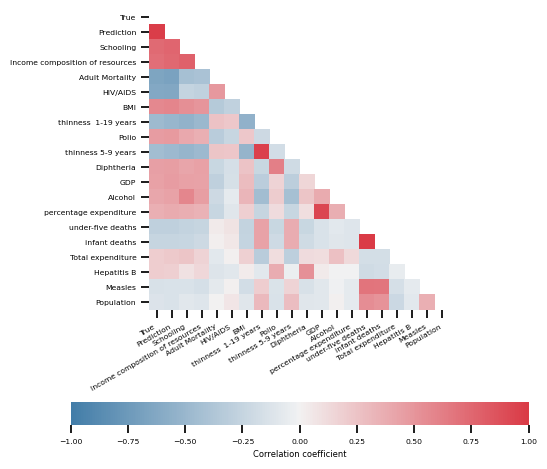

In [35]:
mask = np.triu(np.ones_like(corr_matrix))
ax = sns.heatmap(corr_matrix, mask=mask, center=0, vmin=-1, vmax=1, square=True, cmap=cmap, cbar_kws=cbar_kws)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()

#### More training results observations
- The model had a high r^2 square, so it isn't the predicted value correlates strongly with the true value
- __The absolute correlation coefficient of 'Prediction' with 'True' (Life expectancy) is 0.24 higher than the absolute correlation coefficient of 'Schooling' with 'True', 'Schooling' being the feature with the hightest absolute correlation coefficient out of all the featues__ 

#### Let's see well the most important features match up with the features with the high absolute correlation coefficients
- 'rr' = Ridge regression
- 'rfr' = Random forest regression

In [98]:
rr_feature_importances = pd.read_csv(os.path.join(ml_results_dir, 'rr_X', 'feature_importances.csv'), index_col=0)
rr_permutation_importances = pd.read_csv(os.path.join(ml_results_dir, 'rr_X', 'permutation_importances.csv'), index_col=0)
rfr_feature_importances = pd.read_csv(os.path.join(ml_results_dir, 'rfr_X', 'feature_importances.csv'), index_col=0)
rfr_permutation_importances = pd.read_csv(os.path.join(ml_results_dir, 'rfr_X', 'permutation_importances.csv'), index_col=0)
rr_feature_importances.head()
rr_permutation_importances.head()
rfr_feature_importances.head()
rfr_permutation_importances.head()

,model_key,model_name,training_x,feature,coefficient,normalized_importance,rank_importance
0,rr,Ridge regression,X,Adult Mortality,-2.673732,1.000000,1.0
11,rr,Ridge regression,X,HIV/AIDS,-2.400391,0.894427,2.0
17,rr,Ridge regression,X,Schooling,2.306665,0.858227,3.0
7,rr,Ridge regression,X,under-five deaths,-1.887347,0.696274,4.0
1,rr,Ridge regression,X,infant deaths,1.837587,0.677055,5.0


,model_key,model_name,training_x,feature,importances_mean,importances_std,normalized_importance,rank_importance
0,rr,Ridge regression,X,Adult Mortality,0.136600,0.011642,1.000000,1.0
11,rr,Ridge regression,X,HIV/AIDS,0.134286,0.009535,0.983166,2.0
17,rr,Ridge regression,X,Schooling,0.086493,0.009095,0.635576,3.0
1,rr,Ridge regression,X,infant deaths,0.069761,0.007415,0.513883,4.0
7,rr,Ridge regression,X,under-five deaths,0.066240,0.008920,0.488277,5.0


,model_key,model_name,training_x,feature,importance,normalized_importance,rank_importance
11,rfr,Random forest regression,X,HIV/AIDS,0.473109,1.000000,1.0
16,rfr,Random forest regression,X,Income composition of resources,0.188012,0.393642,2.0
0,rfr,Random forest regression,X,Adult Mortality,0.174976,0.365915,3.0
17,rfr,Random forest regression,X,Schooling,0.055382,0.111557,4.0
6,rfr,Random forest regression,X,BMI,0.019548,0.035345,5.0


,model_key,model_name,training_x,feature,importances_mean,importances_std,normalized_importance,rank_importance
11,rfr,Random forest regression,X,HIV/AIDS,0.247788,0.016102,1.000000,1.0
0,rfr,Random forest regression,X,Adult Mortality,0.180209,0.011060,0.726709,2.0
16,rfr,Random forest regression,X,Income composition of resources,0.124216,0.009760,0.500274,3.0
17,rfr,Random forest regression,X,Schooling,0.012055,0.001385,0.046697,4.0
6,rfr,Random forest regression,X,BMI,0.009579,0.001982,0.036685,5.0


In [99]:
rr_feature_importance_intersection = (set(rr_feature_importances.iloc[0:5]['feature'])
                                   .intersection(rr_permutation_importances.iloc[0:5]['feature']))
len(rr_feature_importance_intersection)
rr_feature_importance_intersection
rfr_feature_importance_intersection = (set(rfr_feature_importances.iloc[0:5]['feature'])
                                   .intersection(rfr_permutation_importances.iloc[0:5]['feature']))
len(rfr_feature_importance_intersection)
rfr_feature_importance_intersection
feature_importance_intersection = (rr_feature_importance_intersection
                                   .intersection(rfr_feature_importance_intersection))
len(feature_importance_intersection)
feature_importance_intersection

5

{'Adult Mortality',
 'HIV/AIDS',
 'Schooling',
 'infant deaths',
 'under-five deaths'}

5

{'Adult Mortality',
 'BMI',
 'HIV/AIDS',
 'Income composition of resources',
 'Schooling'}

3

{'Adult Mortality', 'HIV/AIDS', 'Schooling'}

#### Investigating features strongly correlated with the target variable, model feature importance, and multicollinearity
- We will arbitrarily focus on the top 5: 
    - Features highly correlated with the target variable 
    - Features ranked by permutation importance for the models
- The top 5 features for both the feature importances returned by the model and the permutation feature importances overlap perfectly for the respective model types (ridge regression and random forest regressor)
- The values from the feature importances returned by the model will be examined further
- Note: see https://scikit-learn.org/stable/modules/permutation_importance.html section 4.2

In [101]:
rr_feature_importances = (rr_feature_importances
                              .set_index(keys=['feature'], drop=True)
                              .reindex(['coefficient', 'normalized_importance', 'rank_importance'], axis=1)
                              .add_prefix('rr_'))
rfr_feature_importances = (rfr_feature_importances
                              .set_index(keys=['feature'], drop=True)
                              .reindex(['normalized_importance', 'rank_importance'], axis=1)
                              .add_prefix('rfr_'))
rr_feature_importances.head()
rfr_feature_importances.head()

,rr_coefficient,rr_normalized_importance,rr_rank_importance
feature,,,
Adult Mortality,-2.673732,1.000000,1.0
HIV/AIDS,-2.400391,0.894427,2.0
Schooling,2.306665,0.858227,3.0
under-five deaths,-1.887347,0.696274,4.0
infant deaths,1.837587,0.677055,5.0


,rfr_normalized_importance,rfr_rank_importance
feature,,
HIV/AIDS,1.000000,1.0
Income composition of resources,0.393642,2.0
Adult Mortality,0.365915,3.0
Schooling,0.111557,4.0
BMI,0.035345,5.0


In [102]:
# the first 2 indexes are 'True' and 'Prediction'
top_5_correlated_features = set(corr_matrix.iloc[2:7].index)
len(top_5_correlated_features)
top_5_correlated_features

5

{'Adult Mortality',
 'BMI',
 'HIV/AIDS',
 'Income composition of resources',
 'Schooling'}

In [103]:
features_to_check = list(rfr_feature_importance_intersection
                         .union(rr_feature_importance_intersection)
                         .union(top_5_correlated_features))
len(features_to_check)
features_to_check

7

['Schooling',
 'BMI',
 'infant deaths',
 'under-five deaths',
 'Income composition of resources',
 'Adult Mortality',
 'HIV/AIDS']

In [105]:
top_5_feature_comparison = (corr_matrix.reindex(features_to_check)['True']
                            .to_frame().rename({'True': 'Correlation coefficient'}, axis=1))
top_5_feature_comparison = (top_5_feature_comparison
                            .join(rr_feature_importances)
                            .join(rfr_feature_importances)
                            .sort_values(by=['rfr_rank_importance']))
top_5_feature_comparison

,Correlation coefficient,rr_coefficient,rr_normalized_importance,rr_rank_importance,rfr_normalized_importance,rfr_rank_importance
HIV/AIDS,-0.619533,-2.400391,0.894427,2.0,1.000000,1.0
Income composition of resources,0.713674,1.369928,0.496430,6.0,0.393642,2.0
Adult Mortality,-0.653189,-2.673732,1.000000,1.0,0.365915,3.0
Schooling,0.740869,2.306665,0.858227,3.0,0.111557,4.0
BMI,0.570463,0.835645,0.290073,8.0,0.035345,5.0
under-five deaths,-0.286944,-1.887347,0.696274,4.0,0.014944,8.0
infant deaths,-0.248139,1.837587,0.677055,5.0,0.007061,10.0


In [91]:
# Calculate the variance inflation factor using these features
vif_df = utils.compute_vif(Xy_test, features_to_check).sort_values(by=['VIF'], ascending=False)
vif_df

,Variable,VIF
3,under-five deaths,79.539577
2,infant deaths,78.848090
0,Schooling,2.857866
4,Income composition of resources,2.847146
5,Adult Mortality,1.537851
1,BMI,1.444373
6,HIV/AIDS,1.363943


#### Observations of features strongly correlated with the target variable, model feature importance, and multicollinearity
- Although 'Schooling' correlates the most strongly with the target variable, it is not the most important feature in either model, and its normalized importance for the random forest is about 1/10 of the feature ranked above it. Possible reasons include:
    - The stochastic nature of feature regularizaiton and selection
    - Multicollinearity could have affected the feature selection or regularizaiton during training
- The sign (+/-) of the correlation coefficeint and the model feature coefficeint of the top 4 ranked features for ridge regression match, which makes sense, since _a positive coefficient indicates that as the value of the independent variable increases, the mean of the dependent variable also tends to increase. A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease_. This breaks down as the importance of the feature decreases.
    - https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/
- Removing the variables wit a high VIF (variables that are highly correlated with other variables) and using different random states for training the models and splitting the data would lead to different importance values and possibly different hyperparamter selection
- __But...it is well accepted that multicollinearity has little impact on the model's performance, so experimenting with the above feature selection would just be to investigate feature importance and hyperparamter stability.__